# Linear Regression to predict wine score

## Task1. Train a linear model
    - using least squares method
    - implement the model from scratch using NumPy 
    - Use learning curves plot to understand whether the linear moel is overfitting or underfitting
We will use the winequality dataset for this practical. The original dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality. 
In order to make it easier to import the dataset, the dataset has been converted to the numpy array format and shuffled. you can find out the datset in dataset repository.





### 1.1 load the package

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

### 1.2 load the dataset 

In [2]:
# load the white wine dataset
# X is the feature matrix that stores the feature values of the data records
# y is the label vector that stores the labels of the data records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a {} matrix, which contains {} data records and {} features.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a {}-dimentional vector, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a (4898, 11) matrix, which contains 4898 data records and 11 features.
y is a 4898-dimentional vector, which stores the corresponding labels of the data records in X


### 1.3 split traing/test dataset 
In practice, we should sample randomly 80% of the data as training data and the rest as the test data.

In [3]:

def split_data(X, y, split_coeff):
  '''
  The parameter split_coeff is a percentage value such that
  the first split_coeff of the dataset goes to the training dataset 
  and the remaining data goes to the test dataset.
  '''
  N, _ = X.shape # get the number of records (rows)
  train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
  X_train = X[:train_size] # the first training_size records
  y_train = y[:train_size]
  X_test = X[train_size:] # the last test_size records
  y_test = y[train_size:]
  
  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # split the data with split_coeff=0.8

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


### 1.4 understand datasets 
Let’s first check
the distribution of the y-values in the training data.  
Make a bar chart showing the distribution of y-values in the training data then you will find that the values are integers between 3 and 9 indicating the quality of the wine.  


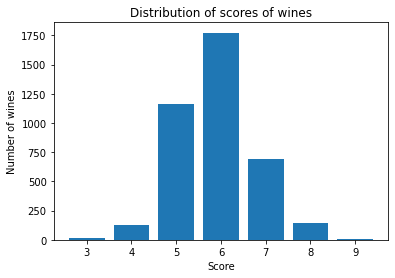

In [4]:
def plot_bar_chart_score(y_train):

    y_train_ints = np.array(y_train)
    y_train_counts = np.bincount(y_train_ints.astype('int'))
    x_labels = np.nonzero(y_train_counts)[0]

    plt.title("Distribution of scores of wines")
    plt.xlabel("Score")
    plt.ylabel("Number of wines")
    plt.bar(x_labels, y_train_counts[y_train_counts != 0])
    plt.show()

plot_bar_chart_score(y_train)

### 1.5 implement baseline model
build a trivial predictor, which always returns the mean of the y-values of the training data. The linear regression models we build later should perform better than this trivial model.

In [5]:
def compute_average(y_train):
    return np.mean(y_train)

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The trivial predictor returns the average value.
def trivial_predictor(X_test, y_train_avg):
  return y_train_avg


Average of y on the training label values is 5.878764675855028


### 1.6 test baseline model 
we now evaluate the trivial predictor on the training data and test data. We use mean squared error (MSE) to measure the performance of the predictor. 

In [6]:
# Implement a function that can report the mean squared error of a predictor on the given data
# Input: data and predictor
# Output: mean squared error of the predictor on the given data

def test_predictor(X, y, predictor: callable=None):
    
    y_predicted = np.apply_along_axis(predictor, 1, X) # apply the predictor to each row of X to get the predictions
    mse = np.square(np.subtract(y, y_predicted)).mean() # compute mse

    return mse

# we use the lambda function here to pass the function trivial predictor to the function test_predictor.
mse_trivial_predictor_train = test_predictor(X_train, y_train, lambda x: trivial_predictor(x, y_train_avg))
mse_trivial_predictor_test = test_predictor(X_test, y_test, lambda x: trivial_predictor(x, y_train_avg))

# Report the result
print('Trivial Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_trivial_predictor_train)
print('MSE (Testing)  = %.4f' % mse_trivial_predictor_test)

Trivial Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


### 1.7 standardize the datasets
Before training the model, we need to standardize the data, i.e., transform the data so that every feature has mean 0 and variance 1. 

https://en.wikipedia.org/wiki/Standard_score

We first standardize the training data. 
Then we apply the same transformation to the test data, i.e. standardize the test data using the means and the standard deviations of the training data. 

In [7]:
# implement a function that can standardize the data and returns the mean and std of the data.
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    mean = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_std = (X - mean)/sigma

    return X_std, mean, sigma

# Standardize the teaining data 
X_train_std, X_train_mean, X_train_sigma = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_sigma)

# Standardize the test data using the means and standrad deviations of the training data
X_test_std = (X_test - X_train_mean)/X_train_sigma
print(X_test_std.shape)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]
(980, 11)


#### Note : We have standardized X-values. Do we need to standardize the y-values? Why?  
We don't need to standarize the y-value. The reason why we standardize X-value is it is input of linear regression model which includes interaction terms and polynomial terms. This means that if the independent variables (each features) have significant difference in scale, bias can be introduced in those terms and mislead the result. However, y-values are output value of our model, which has only one feature : quality of wine scored between 1 to 9. Accordingly, it makes more sense to keep the y-values as original values, otherwise standarization will rather change the meaning of score. For this reason standatization for y-value is unneccessary. 
  


### 1.8 Train the Linear Model using Least Squares Method

Let us train a linear model on the training data and then check its MSE. 
We use the closed form solution of the least squares estimate to get the parameters of the linear model.  

 * Don't forget to add the bias term to the matrix X. 
 * The linear model should perform better than the trivial predictor which returns simple mean of the labels!



In [8]:
# implement a function that adds a column of ones to the front of the input matrix
def expand_with_ones(X):

    n, m = X.shape
    X_ones = np.ones((n,1))
    X_out = np.hstack((X_ones,X))
    
    return X_out

def least_squares_compute_parameters(X_input, y):
    # 1. add the bias column to the data
    X = expand_with_ones(X_input)

    # 2. compute the weight based on the expanded X and y using the least-squares method
    XT = np.transpose(X)
    w = np.dot(np.dot(np.linalg.inv(np.dot(XT,X)),XT),y)

    return w

w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


In [9]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    return np.dot(X, w)


### 1.9 Evaluate the linear model 
using test datset and compute its mse 

In [10]:
# use the function test_predictor to evaluate the linear model predictor
mse_linear_model_predictor = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283472


### 1.10 plot the Learning curve


Let us check if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, the model shouldn't be overfitting.  

To check it, we need to check the learning curves, i.e. how the performance of the model changes when it is trained with increasingly more data. 
We train the model on the increasingly more data ([20, 40, ..., 600] data records), and evaluate the model by computing the MSE of the model on both the training data and the test data. 


In [11]:
# Input: training data and test data
# Output: mse of the linear model predictor on both the training and test data
def train_and_test(X_train, y_train, X_test, y_test):
    
    #1. standarize
    X_train_std, X_train_mean, X_train_sigma = standardize_data(X_train)
    X_test_std = (X_test - X_train_mean)/X_train_sigma

    #2. calculate w 
    W = least_squares_compute_parameters(X_train_std, y_train)

    #3. calculate mse 
    mse_train = test_predictor(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, W))
    mse_test = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, W))

    return mse_train, mse_test

mse_train, mse_test = train_and_test(X_train, y_train, X_test, y_test)

print('Linear Model')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


Linear Model
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5607


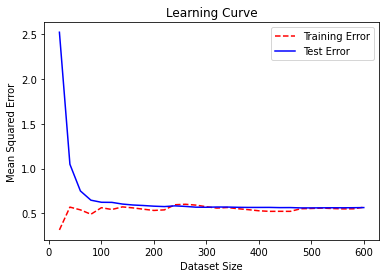

In [12]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the MSE over data with sizes from TRAINING_SIZE_MIN to TRAINING_SIZE_MAX with increasing step 20
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
  #  1. use the first train_size data records from the X_train and y_train as the training data
  #  2. train and compute the MSE on both training and test data using the train_and_test function
  #  3. add the computed MSE to the lists mse_train_v and mse_test_v

    X_train_batch = X[:train_size]
    y_train_batch = y[:train_size]
    mse_train, mse_test = train_and_test(X_train_batch, y_train_batch, X_test, y_test)
    
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)

# The below code generates the learning curves plot
plt.figure(2)
plt.title("Learning Curve")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.legend(loc='upper right')
plt.show()

### 1.11 Interpretation of the result 
Learning curve shows the trend of the training and test error as function of the training data size. In our result, both errors quickly start to plateau and meet at the same level after about 300 data is used. This means adding more data does not decrease both errors. However, in our case, both training and test error is pretty low enough, we can say our model fits and generalizes the dataset well. 

## Task2. Improve linear models with 
    - regularization (Ridge and Lasso)
    - polynomial basis expansion
    - use validation data to choose the hyperparameters
    - Use k-fold cross validation to choose the optimal hyperparameters

### 2.1 import pakages


In [13]:
# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

### 2.2 expand basis
Let's implement the function for expanding the basis of the dataset using `PolynomialFeatures`

In [14]:
def expand_basis(X, degree):
    # expand the basis of X for the input degree
    poly = PolynomialFeatures(degree)
    return poly.fit_transform(X)


### 2.3 Data preparation 
We need to expand and standardize the the data,
and prepare the training, test and validation data.
You should set the last 20% of the training data as the validation data.

* use `StandardScaler` and `std_scaler` to standardize the data

**NOTE**

**Why standardisation is required before basis expansion?**

Assume we have a dataset with two features x1 and x2, where x1 has a small scale while x2 has a large scale. When we perform basis expansion, we  get a new feature x1x2. Since x2 has a larger scale than x1, it is likely x2 will contribute more to the value of the new feature x1x2, which means a bias is introduce here. 
The correct way is to standardise the features before the basis expansion. In this case x1 and x2 have the same scale, so they contribute same to the new feature x1x2, i.e. no bias is introduced. 


**Why standardise the training data in step 5?**

Ridge and Lasso regularisation require the data to have mean of 0 and standard deviation of 1. However, after the basis expansion and splitting in step 4, the training data might not have the desired distribution, so we need to perform the standardisation on the training data. 

 
**Why not standardise both training and validation data together?**

When we use validation data to chose the hyperparameters, we treat the validation data like the test data -- we should not assume we can access these data. So we should standardise the training data and perform the same operation to the validation data. 

In [15]:
def prepare_data(X, y, degree):

    # 1. split the data (X, y) into training data (X_train, y_train) and test data (X_test, y_test)
    # 2. standardize the training data and do the same transformation to the test data
    # 3. expand the basis of the training data and test data
    # 4. split the expanded training data into training data (X_train_n, y_train_n) and validation data (X_train_v, y_train_v)
    # 5. standardize the training data and do the same transformation to the validation data

    #1. split train / test dataset
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)

    #2. standarize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    #3. basis expansion
    X_train = expand_basis(X_train, degree)
    X_test = expand_basis(X_test, degree)

    #4. split train / validation dataset
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)
    
    #5. standarize 
    X_train_n= scaler.fit_transform(X_train_n)
    X_train_v= scaler.transform(X_train_v)


    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test

X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

### 2.4 find hyperparameters (lambda) for Ridge and Lasso model

We use the Ridge and Lasso models from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

We train Ridge or Lasso models with different lambda values (from 10^-4 to 10^2) and check their performance on the validation data. The lambda value that results the best performance is then the optimal lambda.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.680e+02, tolerance: 2.424e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.041e-01, tolerance: 2.424e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


Ridge lambda: 1
Lasso lambda: 0.001


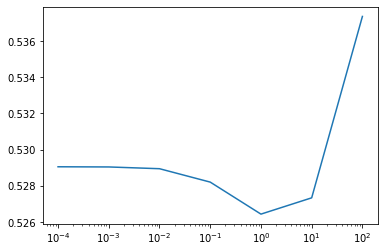

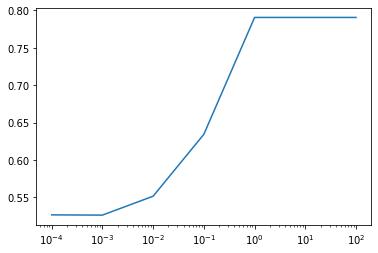

In [16]:
# The function takes the training and validation data as inputs, and returns the lambda value that results the minimal mse
# We use is_ridge to indicate which the model is considered (is_ridge = True indicates Ridge while is_ridge = False indicates Lasso)
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_list = []
    lam_list = []

    for pow_lam in range(-4, 3):
        lam = 10 ** pow_lam

        if is_ridge:
          reg = Ridge(lam)
        else:
          reg = Lasso(lam)
  
        reg.fit(X_train_n, y_train_n)

        y_hat = reg.predict(X_train_v)
        mse = (np.square(y_train_v - y_hat)).mean()

        mse_list.append(mse) 
        lam_list.append(lam)

    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_list))

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_list, mse_list)

    # return the optimal lambda value
    return lam_list[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### 2.5 train models with optimal hyperparameters



In [17]:
params = [("Ridge",Ridge,lam_ridge), ("Lasso",Lasso,lam_lasso)]
res = {}

for param in params:
  res[param[0]] = []

  reg = param[1](param[2])
  reg.fit(X_train, y_train)
  
  y_train_hat = reg.predict(X_train)
  mse_train = (np.square(y_train - y_train_hat)).mean()
  res[param[0]].append(mse_train)
  
  y_test_hat = reg.predict(X_test)
  mse_test = (np.square(y_test - y_test_hat)).mean()
  res[param[0]].append(mse_test)

mse_ridge_train, mse_ridge_test, mse_lasso_train, mse_lasso_test = res["Ridge"][0], res["Ridge"][1], res["Lasso"][0], res["Lasso"][1]


# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 1.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4952
MSE (Testing)  = 0.5125


For Lasso with using degree 2 polynomial expansion and lambda = 0.0010
---------------------------------------------------------------------

MSE (Training) = 0.4962
MSE (Testing)  = 0.5098


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.057e-01, tolerance: 3.043e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


### 2.6  basis expansions with higher degrees 
try basis expansions with higher degrees (up to degree 4) and find the degree that results the best performance. 

Instead of always using the same validation set, you should use k-fold cross validation to find the optimal hyperparameters. (use `KFold`)

report the optimal hyperparameters (the basis expansion degree and the lambdas) and the MSE of the Ridge and Lasso when you apply the optimal hyperparameters. 



In [18]:
from sklearn.model_selection import KFold

In [ ]:
# 1. split dataset to train and test set with the ratio of 80:20
X_train, y_train, X_test, y_test = split_data(X, y, 0.8)

# 2. Standarize input data 
X_train_std, X_train_mean, X_train_sigma = standardize_data(X_train)
X_test_std = (X_test - X_train_mean)/X_train_sigma

# 3. Find a optimal model with different hyperparameters (polynomial bais expansion degree 1 to 4 and regularizer lambda 10^-4 to 10^3)
degree = [1,2,3,4]
lams = [10**x for x in range(-4,4)]
res = { "ridge" : {"mse_list": [],"hyp_list": []}, #degree, lamda
        "lasso" : {"mse_list": [],"hyp_list": []}}
params = [("ridge", Ridge),("lasso", Lasso)]


scaler = StandardScaler()
kf = KFold(n_splits=5)

for i in degree:
  # basis expansion based on different degree 1 to 4
  X_train = expand_basis(X_train_std, i)
  X_test = expand_basis(X_test_std, i)

  mse_list_r = [] # degree i with min lambda of ridge model
  mse_list_l = [] # degree i with min lambda of lasso model

  mse = { "ridge": [],
          "lasso": []}
  lam_list = []

  # test for each model with lambda 10^-4 to 10^3
  for lam in lams:
    kf_mse = { "ridge": [],
                "lasso": []
               }

    # validate with kf = 5 
    for n_i, v_i in kf.split(X_train):
      X_train_n, X_train_v = X_train[n_i], X_train[v_i]
      y_train_n, y_train_v = y_train[n_i], y_train[v_i]

      # standarise train and validation set 
      X_train_n = scaler.fit_transform(X_train_n)
      X_train_v = scaler.transform(X_train_v)

      # train with each regularizer and store mse 
      for param in params:
        reg = param[1](lam)
        reg.fit(X_train_n, y_train_n)
        y_hat = reg.predict(X_train_v)
        mse = (np.square(y_train_v - y_hat)).mean()
        kf_mse[param[0]].append(mse)

    #calculate mean of kf_mse and store
    mse_list_r.append(np.mean(kf_mse["ridge"]))
    mse_list_l.append(np.mean(kf_mse["lasso"])) 
    lam_list.append(lam)

  res["ridge"]["mse_list"].append(min(mse_list_r))
  res["lasso"]["mse_list"].append(min(mse_list_l))

  lambda_idx_min_r = np.argmin(np.array(mse_list_r))
  res["ridge"]["hyp_list"].append((i, lam_list[lambda_idx_min_r]))
  lambda_idx_min_l = np.argmin(np.array(mse_list_l))
  res["lasso"]["hyp_list"].append((i, lam_list[lambda_idx_min_l]))
  


In [20]:
# 4. find optimal hyps

min_mse_r = min(res["ridge"]["mse_list"])
hyp_idx_min_r = np.argmin(np.array(res["ridge"]["mse_list"]))
optimal_hyp_r = res["ridge"]["hyp_list"][hyp_idx_min_r]

min_mse_l = min(res["lasso"]["mse_list"])
hyp_idx_min_l = np.argmin(np.array(res["lasso"]["mse_list"]))
optimal_hyp_l = res["lasso"]["hyp_list"][hyp_idx_min_l]

# 5. report optimal hyps
print("The optimal hyperparameters for Ridge model: degree %d and lambda %4f with validation mse %4f" % (optimal_hyp_r[0], optimal_hyp_r[1], min_mse_r) )
print("The optimal hyperparameters for Lasso model: degree %d and lambda %4f with validation mse %4f" % (optimal_hyp_l[0], optimal_hyp_l[1], min_mse_l) )


The optimal hyperparameters for Ridge model: degree 2 and lambda 10.000000 with validation mse 0.538901
The optimal hyperparameters for Lasso model: degree 2 and lambda 0.001000 with validation mse 0.537769


In [21]:
# 6. Report tarin error and test error of model with optimal hyperpameter 

def mse_optimal(model, lam, X_train, y_train, X_test, y_test):
  reg = model(lam)  
  reg.fit(X_train, y_train)
  y_train_hat = reg.predict(X_train)
  mse_train = (np.square(y_train - y_train_hat)).mean()

  y_test_hat = reg.predict(X_test)
  mse_test = (np.square(y_test - y_test_hat)).mean()

  return mse_train, mse_test

In [22]:
#Split train / test dataset
X_train, y_train, X_test, y_test = split_data(X, y, 0.8)

#standarize
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#basis expansion
X_train = expand_basis(X_train, 2)
X_test = expand_basis(X_test, 2)

# calculate tarin error and test error
mse_ridge_train, mse_ridge_test = mse_optimal(Ridge, optimal_hyp_r[1], X_train, y_train, X_test, y_test)
mse_lasso_train, mse_lasso_test = mse_optimal(Lasso,optimal_hyp_l[1], X_train, y_train, X_test, y_test)

print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.3f' % (optimal_hyp_r[0], optimal_hyp_r[1]))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.3f' % (optimal_hyp_l[0], optimal_hyp_l[1]))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 10.000
--------------------------------------------------------------------------------

MSE (Training) = 0.4955
MSE (Testing)  = 0.5117


For Lasso with using degree 2 polynomial expansion and lambda = 0.001
---------------------------------------------------------------------

MSE (Training) = 0.4962
MSE (Testing)  = 0.5098


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.057e-01, tolerance: 3.043e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


**Interpretation**  

It is interesting that we got different lambda value for Ridge model, even though with the same polynomial degree that we tried above. We think this is because Ridge model is somewwhat sensitive to different train/validation set. it seems around 4000 data set is not enough to get stable results.  